<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-1-Sprint-2-Statistics/blob/master/module1/DS_121_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 2 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

**1. Load and clean the data (or determine the best method to drop observations when running tests)**


Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_1samp

In [2]:
# Load the voting data, converting '?' values to NaN
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data --no-check-certificate
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
voting_df = pd.read_csv('house-votes-84.data', header=None, names=column_headers, na_values='?')

#Recode 'y'/'n' to 1/0
voting_df.replace({'y':1, 'n':0}, inplace=True)

voting_df.sample(5)


--2020-04-09 19:00:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data.1’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2020-04-09 19:00:27 (286 KB/s) - ‘house-votes-84.data.1’ saved [18171/18171]



,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
306,republican,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
111,republican,0.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
349,republican,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
354,democrat,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,1.0,1.0
257,republican,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0


#Functions to separate and explore data, and run unpaired two sample t-tests
(Stretch goal 1)

In [0]:
# function break into separate datasets for each group
def separateGroups(orig_df, column):
  '''
      Separate groups into their own respective dataframes

      orig_df: original dataset
      column: column of the groups
      
      Creates new dataframes with name '{group_name}_df'
      Returns a list of the new dataframes
  '''
  # get list of unique group names
  groups = list(orig_df[column].unique())

  # create new dataframes
  new_dfs = []
  for group in groups:
    new_dfname = group + '_df'
    func = f'{new_dfname} = orig_df[orig_df[column] == \'{group}\']'
    exec(func)
    exec(f'{new_dfname}.name = \'{group}\'')
    exec(f'new_dfs.append({new_dfname})')
  return new_dfs


In [0]:
# function to calculate means for each sample in each group and margins
def calculateMeans(dataframes):
  '''
    Calculate means of all samples, in each datframe, and differences.
    
    dataframes: list of the dataframe names (strings)

    Assumes: two dataframes, first column of each is ignored
    Returns new dataframe with computations
  '''

  # Insure there are two dataframes
  assert(len(dataframes) == 2)

  new_data = {}
  for df in dataframes:
    columns = list(df.columns)
    results = {}
    for column in columns[1:]:
      column_mean = df[column].mean()
      results[column] = column_mean
    new_data[df.name] = results
  new_df = pd.DataFrame(new_data)

  # calculate differences
  new_df['difference'] = new_df[dataframes[0].name] - new_df[dataframes[1].name]
  new_df.sort_values(by='difference', inplace=True)
  new_df.reset_index(inplace=True)
  new_df.rename(columns={'index': 'sample'}, inplace=True)
  return new_df


In [0]:
# Function to run unpaired to sample tests
def test2samp(dfs, samples, alpha):
  ''' 
      Runs two unpaired samples t-test between 2 datasets, 
      comparing shared one or more columns.

      dfs: list of datasets to be compared (must be 2)
      sample: list of columns to be compared
      alpha: alpha level, 1 - CL
      returns a table of results
  '''

  # insure constraint of 2 dataframes
  assert(len(dfs) == 2)

  results = {}
  for sample in samples:
    tvalue, pvalue = ttest_ind(dfs[0][sample], dfs[1][sample], nan_policy='omit')
    hypothesis_0 = pvalue >= alpha
    hypothesis_1 = pvalue < alpha
    results[sample] = {'t-value': tvalue, 
                       'p-value': pvalue,
                       'Hyp-0': hypothesis_0,
                       'Hyp_a': hypothesis_1}

  result_df = pd.DataFrame(results).T
  return result_df



In [0]:
# Function to test all samples, between two dataframes
def alltests(dfs, alpha):
  '''
    Run tests on all samples comparing two dataframes and compile
    dfs: list of dataframes (must be 2)
    alpha: alpha level
  '''
  # must be 2 dataframes to compare
  assert(len(dfs) == 2)

  result_df = test2samp(dfs, column_headers[1:], alpha)
  result_df.reset_index(inplace=True)
  result_df.rename(columns={'index':'sample'}, inplace=True)
  result_df = pd.merge(means_df, result_df, on='sample', how='inner')
  result_df.sort_index()
  return result_df

# Examine data
1) Separate republicans and democrats into respective dataframes  
2) Calculate proportions and differences, to see which appear strongest cases.

In [7]:
dframes = separateGroups(voting_df, 'party')
means_df = calculateMeans(dframes)
means_df

,sample,republican,democrat,difference
0,budget,0.134146,0.888462,-0.754315
1,aid-to-contras,0.152866,0.828897,-0.676031
2,mx-missile,0.115152,0.758065,-0.642913
3,duty-free,0.089744,0.637450,-0.547707
4,anti-satellite-ban,0.240741,0.772201,-0.531460
5,handicapped-infants,0.187879,0.604651,-0.416772
6,synfuels,0.132075,0.505882,-0.373807
7,south-africa,0.657534,0.935135,-0.277601
8,water-project,0.506757,0.502092,0.004665
9,immigration,0.557576,0.471483,0.086093


The differences are negative when democrats vote yes more than republicans, and positive in reverse. This makes it easy to organize the data.

Plotting the differences makes it visual which issues each party has voted more than the other. We will pick a couple of each case to test. Democratic on left, republican on right.)

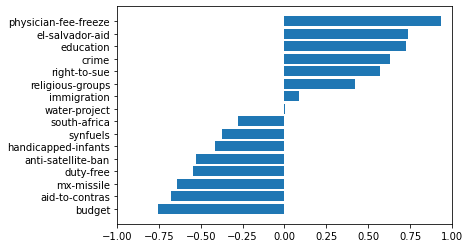

In [8]:
plt.barh(means_df['sample'], means_df['difference'])
plt.xlim(-1,1);

**2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01**

Picking budget and south-africa (democratic extreme end and towards center). Null hypothesis (Hyp-0) is that there is no significant difference. Alternative hypothesis (Hyp-a) is there is.

Rejects null hypothesis.


In [9]:
# First set (budget, south-africa)
issues = ['budget', 'south-africa']
result_df = test2samp(dframes, issues, 0.01)
result_df

,t-value,p-value,Hyp-0,Hyp_a
budget,-23.2128,2.07034e-77,False,True
south-africa,-6.84945,3.65267e-11,False,True


**3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01**

Picking physician-fee-freeze and religious-groups (republican extreme end and towards center). Null hypothesis (Hyp-0) is that there is no significant difference. Alternative hypothesis (Hyp-a) is there is.

Rejects null hypothesis.

In [10]:
# Second set (physician-fee-freeze and religious-groups) alpha=0.05 (99% CL)
issues = ['physician-fee-freeze', 'religious-groups']
result_df = test2samp(dframes, issues, 0.01)
result_df

,t-value,p-value,Hyp-0,Hyp_a
physician-fee-freeze,49.3671,1.99426e-177,False,True
religious-groups,9.73758,2.39367e-20,False,True


**4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)**


Picking water-project and immigration (center most for both parties). Null hypothesis (Hyp-0) is that there is no significant difference. Alternative hypothesis (Hyp-a) is there is.

Rejects null hypothesis for immigration, but fails to reject null hypothesis for water-project.

In [11]:
# Third set (water-project, immigration) alpha=0.1 (90% CL)
issues = ['water-project', 'immigration']
result_df = test2samp(dframes, issues, 0.1)
result_df

,t-value,p-value,Hyp-0,Hyp_a
water-project,0.0889654,0.929156,True,False
immigration,1.73591,0.0833025,False,True


# We'll run tests on all the data too

giving us a complete summary of percentages, differences, and test results, at both alpha levels.

In [12]:
# Test all for alpha of 0.01 (99% CL), for differences in voting
result1_df = alltests(dframes, 0.01)
result1_df

,sample,republican,democrat,difference,t-value,p-value,Hyp-0,Hyp_a
0,budget,0.134146,0.888462,-0.754315,-23.2128,2.07034e-77,False,True
1,aid-to-contras,0.152866,0.828897,-0.676031,-18.0521,2.82472e-54,False,True
2,mx-missile,0.115152,0.758065,-0.642913,-16.4375,5.03079e-47,False,True
3,duty-free,0.089744,0.637450,-0.547707,-12.8531,5.9977e-32,False,True
4,anti-satellite-ban,0.240741,0.772201,-0.531460,-12.5262,8.52103e-31,False,True
5,handicapped-infants,0.187879,0.604651,-0.416772,-9.20526,1.61344e-18,False,True
6,synfuels,0.132075,0.505882,-0.373807,-8.2936,1.57593e-15,False,True
7,south-africa,0.657534,0.935135,-0.277601,-6.84945,3.65267e-11,False,True
8,water-project,0.506757,0.502092,0.004665,0.0889654,0.929156,True,False
9,immigration,0.557576,0.471483,0.086093,1.73591,0.0833025,True,False


In [13]:
# and on which they agree strongly (p > 0.1)
result2_df = alltests(dframes, 0.1)
result2_df

,sample,republican,democrat,difference,t-value,p-value,Hyp-0,Hyp_a
0,budget,0.134146,0.888462,-0.754315,-23.2128,2.07034e-77,False,True
1,aid-to-contras,0.152866,0.828897,-0.676031,-18.0521,2.82472e-54,False,True
2,mx-missile,0.115152,0.758065,-0.642913,-16.4375,5.03079e-47,False,True
3,duty-free,0.089744,0.637450,-0.547707,-12.8531,5.9977e-32,False,True
4,anti-satellite-ban,0.240741,0.772201,-0.531460,-12.5262,8.52103e-31,False,True
5,handicapped-infants,0.187879,0.604651,-0.416772,-9.20526,1.61344e-18,False,True
6,synfuels,0.132075,0.505882,-0.373807,-8.2936,1.57593e-15,False,True
7,south-africa,0.657534,0.935135,-0.277601,-6.84945,3.65267e-11,False,True
8,water-project,0.506757,0.502092,0.004665,0.0889654,0.929156,True,False
9,immigration,0.557576,0.471483,0.086093,1.73591,0.0833025,False,True


#Summarize all those reports

In [14]:
# summarize results
dems_support = list(result1_df[(result1_df['democrat'] > result1_df['republican']) & \
                          (result1_df['p-value'] < 0.01)]['sample'])
reps_support = list(result1_df[(result1_df['democrat'] < result1_df['republican']) & \
                          (result1_df['p-value'] < 0.01)]['sample'])
agree = list(result2_df[result2_df['p-value'] > 0.1]['sample'])
print('Issues democrats support over republicans (p < 0.01):', dems_support)
print('Issues republicans support over democrats (p < 0.01):', reps_support)
print('Issues they agree on (p > 0.1):', agree)

Issues democrats support over republicans (p < 0.01): ['budget', 'aid-to-contras', 'mx-missile', 'duty-free', 'anti-satellite-ban', 'handicapped-infants', 'synfuels', 'south-africa']
Issues republicans support over democrats (p < 0.01): ['religious-groups', 'right-to-sue', 'crime', 'education', 'el-salvador-aid', 'physician-fee-freeze']
Issues they agree on (p > 0.1): ['water-project']


## Stretch Goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables *(Implemented above)*  

2. Work on Performing a T-test without using Scipy in order to get "under the hood" and learn more thoroughly about this topic.  

### Start with a 1-sample t-test
 - Establish the conditions for your test 
 - [Calculate the T Statistic](https://blog.minitab.com/hs-fs/hubfs/Imported_Blog_Media/701f9c0efa98a38fb397f3c3ec459b66.png?width=247&height=172&name=701f9c0efa98a38fb397f3c3ec459b66.png) (You'll need to omit NaN values from your sample).
 - Translate that t-statistic into a P-value. You can use a [table](https://www.google.com/search?q=t+statistic+table) or the [University of Iowa Applet](https://homepage.divms.uiowa.edu/~mbognar/applets/t.html)


 ### Then check your Answers using Scipy!

In [0]:
def our_1sampletest(dframe, sample, mean_0):
  '''
    Implement one sample t-test

    dframe: dataframe
    sample: the column to be tested
    mean_0: the expected mean for null hypothesis

    Returns t-value
  '''

  n = len(dframe[sample])
  # sample mean
  sample_mean = sum(dframe[sample]) / n

  # sample standard deviation
  sample_std = np.sqrt(sum((dframe[sample] - sample_mean) ** 2) / (n - 1))

  # single sample t-test
  t_value = (sample_mean - mean_0) / (sample_std / np.sqrt(n))

  test_results = pd.Series([sample_mean, sample_std, t_value], 
                           index=['mean', 'std', 't_value'])
  return test_results


What we are testing here will be the abstaining rates for both parties. Are they differ from a probability of 5%, let's say. How delinquent are these guys? The null hypothesis is they will be absent about 5% of the time, with a CL of 95%. Are they better (or worse) then that?

In [16]:
# We will want all the votes for each party in one column
republican_tidy = dframes[0].melt(id_vars='party')
democrat_tidy = dframes[1].melt(id_vars='party')

# For these tests on want to recode 0 or 1 to zero, and NaNs to 1, so we can test
# abstentions
republican_tidy.replace({0:0, 1:0}, inplace=True)
republican_tidy.fillna(1, inplace=True)

democrat_tidy.replace({0:0, 1:0}, inplace=True)
democrat_tidy.fillna(1, inplace=True)
republican_tidy.sample(5)


,party,variable,value
2110,republican,right-to-sue,1.0
2665,republican,south-africa,1.0
2100,republican,right-to-sue,0.0
1766,republican,synfuels,0.0
398,republican,budget,0.0


In [0]:
# Our test
from scipy.stats import t

def our_1samp_test(dframe, sample, mean_0, alpha):
  test_values = our_1sampletest(dframe, 'value', mean_0)
  test_values['df'] = len(dframe[sample]) - 1

  # use scipy to get p value from our t statistic
  p =  t.cdf(test_values['t_value'], df=test_values['df'])

  # determine which tail, if t_value > 0 is right, if < 0 left
  p = p if test_values['t_value'] < 0 else 1 - p

  # multiply p value by 2 as two tail test
  test_values['p_value'] = 2 * p

  test_values['hyp_0'] = test_values['p_value'] >= alpha
  test_values['hyp_a'] = test_values['p_value'] < alpha
  return test_values


In [18]:
test_values = our_1samp_test(republican_tidy, 'value', 0.05, 0.01)
test_values

mean          0.048735
std           0.215354
t_value      -0.304517
df         2687.000000
p_value       0.760758
hyp_0         1.000000
hyp_a         0.000000
dtype: float64

In [19]:
# SCIPY test to compare values
ttest_1samp(republican_tidy['value'], 0.05)

Ttest_1sampResult(statistic=-0.3045171372903114, pvalue=0.7607575205691236)

In [20]:
test_values = our_1samp_test(democrat_tidy, 'value', 0.05, 0.01)
test_values

mean          0.061096
std           0.239533
t_value       3.027586
df         4271.000000
p_value       0.002480
hyp_0         0.000000
hyp_a         1.000000
dtype: float64

In [21]:
# SCIPY test to compare values
ttest_1samp(democrat_tidy['value'], 0.05)

Ttest_1sampResult(statistic=3.0275863792291657, pvalue=0.002479871332732574)

Null hypothesis is not rejected on republicans, but it is on the democrats. The latter abstain on votes significantly more than 5% of the time.

 ### Then try a 2-sample t-test
 - Establish the conditions for your test 
 - [Calculate the T Statistic](https://lh3.googleusercontent.com/proxy/rJJ5ZOL9ZDvKOOeBihXoZDgfk7uv1YsRzSQ1Tc10RX-r2HrRpRLVqlE9CWX23csYQXcTniFwlBg3H-qR8MKJPBGnjwndqlhDX3JxoDE5Yg) (You'll need to omit NaN values from your sample).
 - Translate that t-statistic into a P-value. You can use a [table](https://www.google.com/search?q=t+statistic+table) or the [University of Iowa Applet](https://homepage.divms.uiowa.edu/~mbognar/applets/t.html)


In [0]:
def our_2sampletest(dframe1, dframe2, sample1, sample2):
  '''
    Implement unpaired two sample t-test

    dframe1, dframe2: dataframes to compare
    sample1, sample2: the samples to be tested

    Returns t-value
  '''

  n_1 = len(dframe1[sample1])
  n_2 = len(dframe2[sample2])

  # sample means
  sample1_mean = sum(dframe1[sample1]) / n_1
  sample2_mean = sum(dframe2[sample2]) / n_2

  # sample standard deviation
  var_common = (sum((dframe1[sample1] - sample1_mean)**2) + \
                sum((dframe2[sample2] - sample2_mean)**2)) / \
                (n_1 + n_2 - 2)

  # unpaired two sample t-test
  t_value = (sample1_mean - sample2_mean) / np.sqrt(var_common / n_1 + \
                                                       var_common / n_2)

  test_results = pd.Series([sample1_mean, sample2_mean, t_value],
                           index = ['mean1', 'mean2', 't_value'])
  return test_results

How much do their absenteeism differ? Null hypothesis is that they do not differ signicantly. 99% CL.

In [0]:
def our_2samp_test(dframe1, dframe2, sample1, sample2, alpha):

  test_values = our_2sampletest(dframe1, dframe2, sample1, sample2)
  test_values['df'] = len(dframe1[sample1]) + len(dframe2[sample2]) - 2

  # use scipy to get p value from our t statistic
  p =  t.cdf(test_values['t_value'], df=test_values['df'])

  # determine which tail, if t_value < 0 is left, if > 0 then right
  p = p if test_values['t_value'] < 0 else 1 - p

  # multiply p by 2 as two tail test
  test_values['p_value'] = 2 * p

  test_values['hyp_0'] = test_values['p_value'] >= alpha
  test_values['hyp_a'] = test_values['p_value'] < alpha
  return test_values

In [26]:
our_2samp_test(republican_tidy, democrat_tidy, 'value', 'value', 0.01)

mean1         0.048735
mean2         0.061096
t_value      -2.178176
df         6958.000000
p_value       0.029426
hyp_0         1.000000
hyp_a         0.000000
dtype: float64

In [27]:
# SCIPY test to compare values
ttest_ind(republican_tidy['value'], democrat_tidy['value'])


Ttest_indResult(statistic=-2.178175806985032, pvalue=0.02942641269835807)

Null hypothesis is not rejected. Their rates of abstaining on votes does not differ significantly.
